In [1]:
import pandas as pd
import numpy as np
import xgboost
from sklearn import metrics
import matplotlib.pyplot as plt
import shap
from xgboost import plot_importance
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
import lightgbm

In [2]:
def train_test_split(train, train_len, col, cols):
    t_len = int(len(train) * train_len)
#     t_len = -10
    train_x = train[:t_len]
    train_y = train[:t_len][col]
    test_x = train[t_len:].copy()
    test_y = test_x[col]
    return train_x[cols], train_y, test_x[cols], test_y

In [3]:
cols = ['week','year', 'month', 'discount', 'dis', 'price', 'hao', 'p', 'c', 'h', 'ahao', 'ap', 'ac', 'pv', 'uv', 'sc', 'jg', 'avgst',
        'se','WeeksAgoNum', 'twoWeeksAgoNum']
sales = pd.read_csv('../cache/train/AA035409.csv').fillna(0)
train_x, train_y, test_x, test_y = train_test_split(sales, 0.8, 'total',cols)

In [4]:
# param = {'max_depth': 5, 'gamma': 0.1, 'eta': 0.2, 'nthread': 4, 'seed': 10}
# train = xgboost.DMatrix(train_x, label=train_y)
# test = xgboost.DMatrix(test_x)
# model = xgboost.train(param, train, num_boost_round=200)
# preds = model.predict(test)
# model = xgboost.XGBRegressor(colsample_bytree=0.4603, gamma=0.0468,
#                              learning_rate=0.05, max_depth=5,
#                              min_child_weight=2, n_estimators=2200,
#                              reg_alpha=0.4640, reg_lambda=0.8571,
#                              subsample=0.5213, silent=True,
#                              random_state=7, nthread=-1)
# model = xgboost.XGBRegressor(max_depth=5, learning_rate=0.1, n_estimators=500, nthread=4, silent=True, objective='reg:gamma')
# model = xgboost.XGBRegressor(max_depth=5, learning_rate=0.1, n_estimators=500, silent=False, objective='reg:squarederror')
# model.fit(train_x, train_y)
# preds = model.predict(test_x)

In [5]:
model = lightgbm.LGBMRegressor(objective='regression', num_leaves=5**2,learning_rate=0.01, n_estimators=720,max_bin=55, bagging_fraction=0.8,
                              bagging_freq=5, feature_fraction=0.2319,feature_fraction_seed=9, bagging_seed=9,
                              min_data_in_leaf=6, min_sum_hessian_in_leaf=11)
model.fit(train_x, train_y)
booster = model.booster_
lgb_importance = booster.feature_importance(importance_type='split')
lgb_out = np.argsort(lgb_importance)

preds = model.predict(test_x)
# print(np.sqrt(mean_squared_error(test_y, preds)))

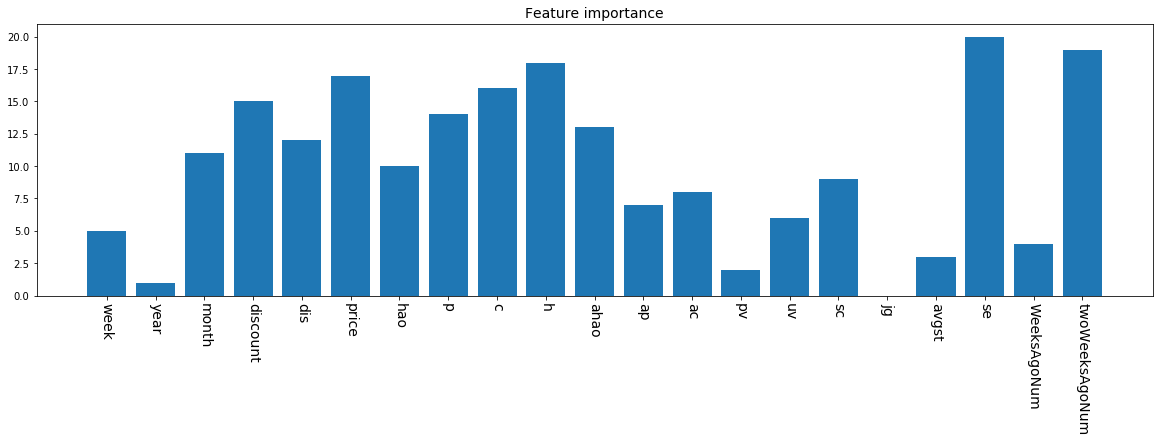

In [6]:
plt.figure(figsize=(20, 5))
plt.bar(range(len(cols)), lgb_out)
plt.xticks(range(len(cols)), cols, rotation=-90, fontsize=14)
plt.title('Feature importance', fontsize=14)
plt.show()

In [7]:
predictions = [round(value) for value in preds]
# # evaluate predictions
accuracy = accuracy_score(test_y.tolist(), predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 0.00%


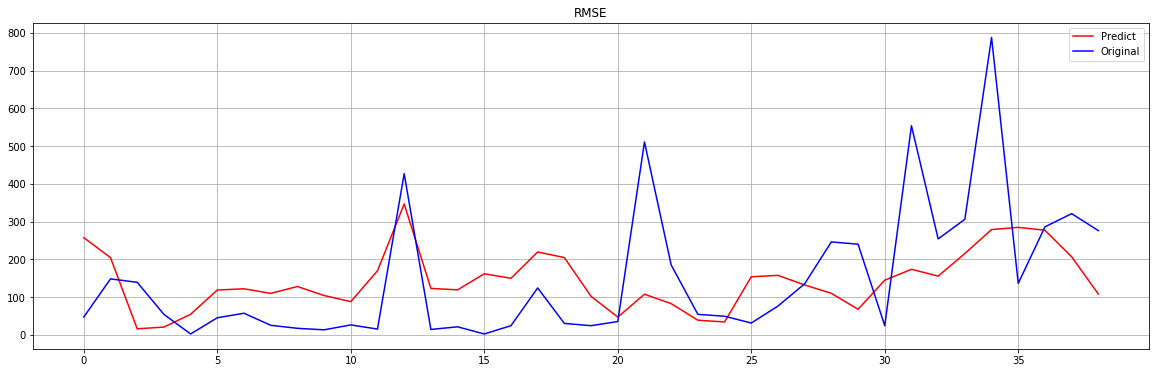

In [8]:
test_true_data = pd.DataFrame(data={'actual': test_y.values})
test_pred_data = pd.DataFrame(data={'prediction': preds})
plt.figure()
test_pred_data.prediction.plot(color='red', label='Predict', figsize=(20, 6))
test_true_data.actual.plot(color='blue', label='Original', figsize=(20, 6))
plt.title('RMSE')
plt.legend(loc='best')  # 将样例显示出来
plt.grid(True)
plt.show()

In [9]:
# 显示重要特征
# plot_importance(model)
# plt.show()
# plt.figure(figsize=(20, 5))
# plt.bar(range(len(cols)), model.feature_importances_)
# plt.xticks(range(len(cols)), cols, rotation=-90, fontsize=14)
# plt.title('Feature importance', fontsize=14)
# plt.show()

In [10]:
# parameters = {
# 'max_depth': [5, 10, 15, 20, 25],
# 'learning_rate': [0.01, 0.02, 0.05, 0.1, 0.15],
# 'n_estimators': [500, 1000, 2000, 3000, 5000],
# 'min_child_weight': [0, 2, 5, 10, 20],
# 'max_delta_step': [0, 0.2, 0.6, 1, 2],
# 'subsample': [0.6, 0.7, 0.8, 0.85, 0.95],
# 'colsample_bytree': [0.5, 0.6, 0.7, 0.8, 0.9],
# 'reg_alpha': [0, 0.25, 0.5, 0.75, 1],
# 'reg_lambda': [0.2, 0.4, 0.6, 0.8, 1],
# 'scale_pos_weight': [0.2, 0.4, 0.6, 0.8, 1]
# }
# xlf = xgboost.XGBClassifier(max_depth=10,
#             learning_rate=0.01,
#             n_estimators=200,
#             silent=True,
#             objective='binary:logistic',
#             nthread=4,
#             gamma=0,
#             min_child_weight=1,
#             max_delta_step=0,
#             subsample=0.85,
#             colsample_bytree=0.7,
#             colsample_bylevel=1,
#             reg_alpha=0,
#             reg_lambda=1,
#             scale_pos_weight=1,
#             seed=1440,
#             missing=None)
# # 有了gridsearch我们便不需要fit函数
# gsearch = GridSearchCV(xlf, param_grid=parameters, scoring='accuracy', cv=3)
# gsearch.fit(train_x, train_y)

# print("Best score: %0.3f" % gsearch.best_score_)
# print("Best parameters set:")
# best_parameters = gsearch.best_estimator_.get_params()
# for param_name in sorted(parameters.keys()):
#     print("\t%s: %r" % (param_name, best_parameters[param_name]))